In [1]:
# ml_pipeline.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns

scaler = MinMaxScaler()

In [2]:
# 1. Load Dataset
# Load features with editing efficiency
df = pd.read_csv("OneHot_encoded_featture_input_GATA1HbF1.csv")
df['editsStatus'] = df['editsStatus'].replace({'N': 0, 'Y': 1})
#df=df.loc[df['editsStatus']=='Y'].copy(deep=True)
#df['Freq'] = df['Freq']*df['editsStatus']

# 1. Get unique IDs
unique_ids = df['guide'].unique()

# 2. Split unique IDs
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# 3. Split the data based on IDs
train_df = df[df['guide'].isin(train_ids)].reset_index(drop=True)
test_df  = df[df['guide'].isin(test_ids)].reset_index(drop=True)

# Split into features (X) and target (y)
X_train = train_df.drop(columns=['Freq',"num_edits","guide_id", "EditEff","editsStatus","guide"])
y_train = pd.DataFrame({"EditEff":train_df["editsStatus"]}, dtype=int)
#X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#y_train_scaled = pd.DataFrame(scaler.fit_transform(y_train), columns=y_train.columns)
y_train = y_train['EditEff']
# Split into training/test sets
groups = train_df["guide"]  # This must uniquely identify each gRNA (same for replicates)

X_test = test_df.drop(columns=['Freq',"num_edits","guide_id", "EditEff","editsStatus","guide"])
y_test = pd.DataFrame({"EditEff":test_df["editsStatus"]}, dtype=int)

#X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#y_test_scaled = pd.DataFrame(scaler.fit_transform(y_test), columns=y_test.columns)
y_test = y_test['EditEff']


/tmp/ipykernel_804456/2503479358.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['editsStatus'] = df['editsStatus'].replace({'N': 0, 'Y': 1})


In [4]:
# 4. Model Training

XGBC_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# 4. Train Model
XGBC_model.fit(X_train, y_train)

# 5. Predict on Test Set
y_pred = XGBC_model.predict(X_test)

# 6. Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))#, target_names=y_test.EditEff))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


/home/anaconda3/envs/aiml/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:40:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      2449
           1       0.00      0.00      0.00       662

    accuracy                           0.79      3111
   macro avg       0.39      0.50      0.44      3111
weighted avg       0.62      0.79      0.69      3111

Confusion Matrix:
[[2449    0]
 [ 662    0]]
Accuracy: 0.7872


/home/anaconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anaconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anaconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


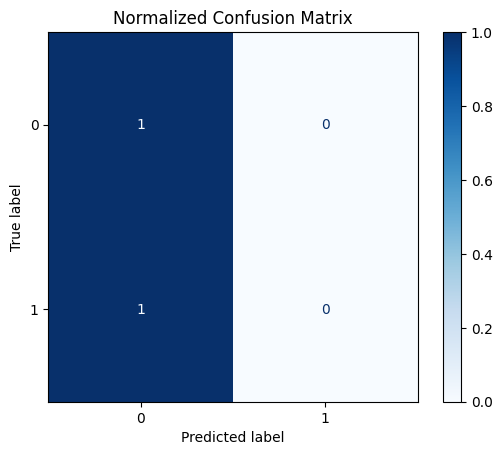

In [5]:
# 7. Plot Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    XGBC_model, X_test, y_test, #display_labels=y_test.EditEff,
    cmap=plt.cm.Blues, normalize='true'
)
plt.title("Normalized Confusion Matrix")
plt.show(block=False)

 AUC score : 0.5039


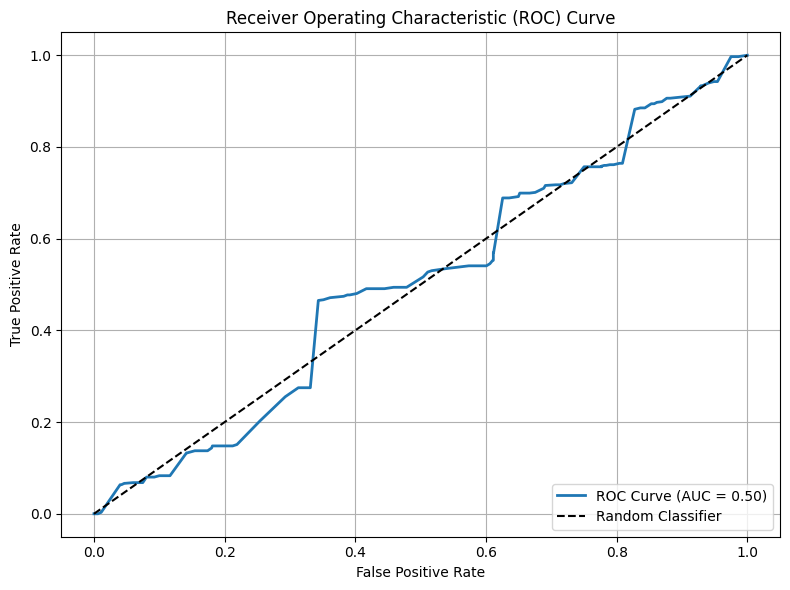

In [6]:
y_prob = XGBC_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,  y_prob)
auc_score = roc_auc_score(y_test,  y_prob)
print(f" AUC score : {auc_score:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

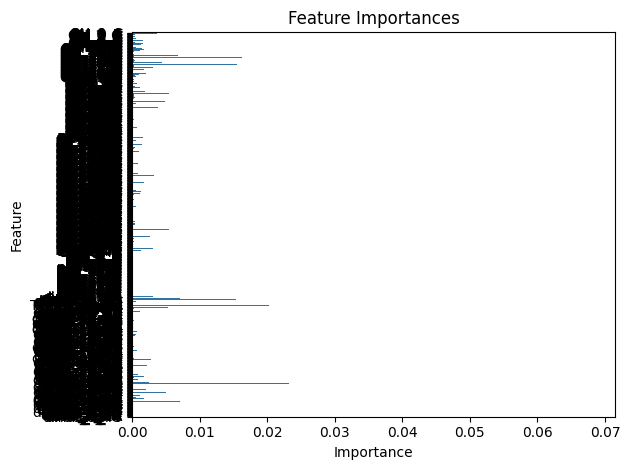

In [7]:
# 8. Feature Importance Plot
importances = XGBC_model.feature_importances_
feature_names = X_train.columns

# Plotting
sns.barplot(x=importances, y=feature_names, orient='h')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show(block=False)


In [8]:
# 9. Optional: Hyperparameter Tuning
# Uncomment to perform a grid search

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(XGBClassifier(random_state=42),
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
best_model = grid_search.best_estimator_

best_pred = best_model.predict(X_test)

/home/anaconda3/envs/aiml/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anaconda3/envs/aiml/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anaconda3/envs/aiml/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anaconda3/envs/aiml/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anaconda3/envs/aiml/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03

Best parameters found: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}


Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      2449
           1       0.00      0.00      0.00       662

    accuracy                           0.79      3111
   macro avg       0.39      0.50      0.44      3111
weighted avg       0.62      0.79      0.69      3111

Best Model Confusion Matrix:
[[2449    0]
 [ 662    0]]
Best Model Accuracy: 0.7872


/home/anaconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anaconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anaconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


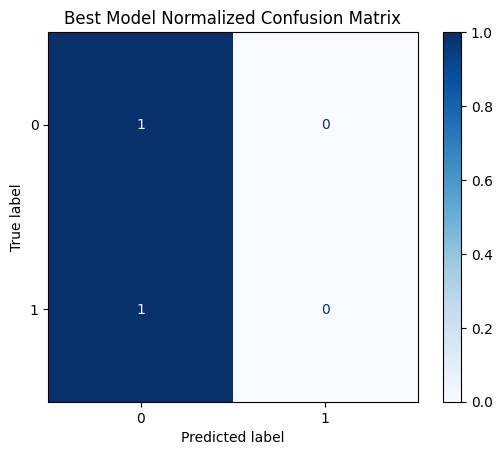

In [9]:
# 6. Evaluation
print("Best Model Classification Report:")
print(classification_report(y_test, best_pred))#, target_names=y_test.EditEff))

print("Best Model Confusion Matrix:")
print(confusion_matrix(y_test, best_pred))

print(f"Best Model Accuracy: {accuracy_score(y_test, best_pred):.4f}")

# 7. Plot Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test, #display_labels=y_test.EditEff,
    cmap=plt.cm.Blues, normalize='true'
)
plt.title("Best Model Normalized Confusion Matrix")
plt.show(block=False)

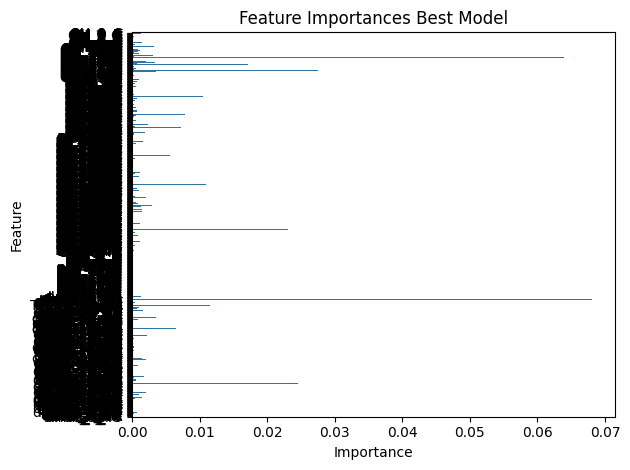

In [10]:

# 8. Feature Importance Plot
importances = best_model.feature_importances_
feature_names = X_train.columns

# Plotting
sns.barplot(x=importances, y=feature_names, orient='h')
plt.title("Feature Importances Best Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show(block=False)

 AUC score : 0.5596


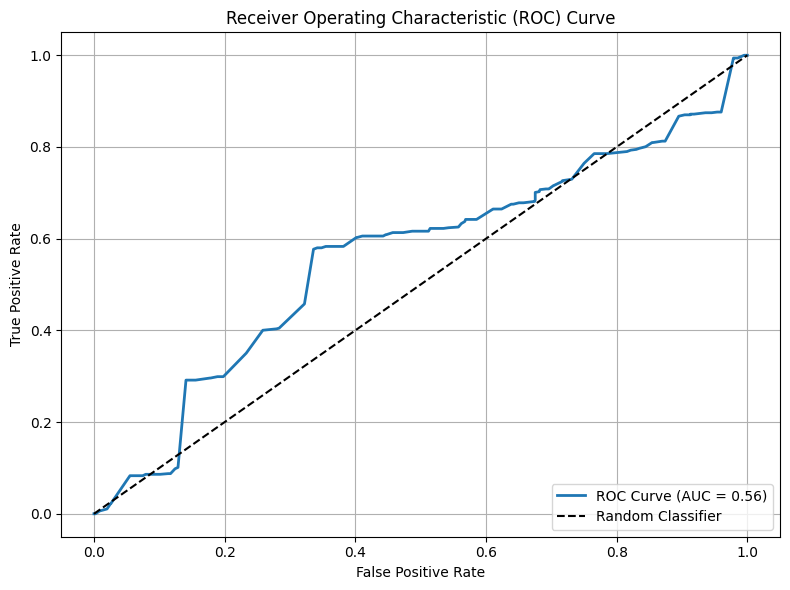

In [11]:
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,  y_prob)
auc_score = roc_auc_score(y_test,  y_prob)
print(f" AUC score : {auc_score:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
